In [ ]:
import csv
import torch

def load_patch_details(csv_path, indices):
    details = []
    with open(csv_path, mode='r', newline='') as file:
        reader = csv.DictReader(file)
        for idx, row in enumerate(reader):
            if idx in indices:
                patch = torch.load(row['file_path'])  # Load the tensor from file
                # Convert the comma-separated string back to a tensor
                camera_position = torch.tensor([float(num) for num in row['camera_position'].split(',')])
                ray_direction = torch.tensor([float(num) for num in row['ray_direction'].split(',')])
                lod_level = row['lod_level']
                view_index = row['view_index']
                details.append((patch, camera_position, ray_direction, lod_level, view_index))
                if len(details) == len(indices):
                    break

    return details

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv

def visualize_multiple_patches(details):
    """
    Visualize camera positions, ray directions, and image patches for multiple entries
    in a 4x(N) grid where N is the number of details.

    Args:
        details (list of tuples): Each tuple contains patch, camera position, and ray direction tensors.
    """
    num_details = len(details)
    fig = plt.figure(figsize=(24, 6 * num_details))  # Adjust figure size if necessary

    for index, (patch, camera_position, ray_direction, lod_level, view_index) in enumerate(details):
        # Calculate subplot indices for 4x(N) layout
        row_index = index // 2  # Row index for N entries, two plots per entry
        col_index = 2 * (index % 2)  # Column index, alternating between 0 and 2
        # 3D subplot for camera position and ray direction
        ax1 = fig.add_subplot(num_details, 4, row_index * 4 + col_index + 1, projection='3d')
        ray_dir_normalized = ray_direction / ray_direction.norm()
        cam_pos = camera_position
        ax1.scatter(cam_pos[0], cam_pos[1], cam_pos[2], color='red', s=100, label='Camera Position')
        ax1.quiver(cam_pos[0], cam_pos[1], cam_pos[2],
                   ray_dir_normalized[0], ray_dir_normalized[1], ray_dir_normalized[2],
                   length=1.0, color='blue', label='Viewing Direction')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
        ax1.legend()
        ax1.set_title(f'3D View of Camera and Direction: Entry {index+1}')
        ax1.set_xlim([cam_pos[0] - 2, cam_pos[0] + 2])
        ax1.set_ylim([cam_pos[1] - 2, cam_pos[1] + 2])
        ax1.set_zlim([cam_pos[2] - 2, cam_pos[2] + 2])

        # 2D subplot for the patch
        ax2 = fig.add_subplot(num_details, 4, row_index * 4 + col_index + 2)
        if patch.dim() == 3 and patch.shape[0] == 3:
            patch_image = patch.permute(1, 2, 0).cpu().numpy()
        else:
            patch_image = patch.numpy()
        ax2.imshow(patch_image)
        ax2.set_title(f'Image Patch: LOD {lod_level}')
        ax2.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
csv_path = 'playroom_dataset/metadata.csv'
indices_to_load = range(0,30) # Indices of the rows you want to load and visualize

# Load the patches
patch_details = load_patch_details(csv_path, indices_to_load)

# Visualize the loaded patches
visualize_multiple_patches(patch_details)

In [ ]:

import pandas as pd
from dataset.lod_vdp_dataset import LODVDPDataset
import matplotlib.pyplot as plt

dataset_dir = 'dataset/lod_ecc_dataset'
dataset = LODVDPDataset(dataset_dir)
dataset.metadata['LOD_pair'] = dataset.metadata.apply(
    lambda row: tuple(sorted([row['LOD_X'], row['LOD_N']])), axis=1
)
# Group by the normalized LOD_pair
grouped = dataset.metadata.groupby('LOD_pair')
tables = {}
for name, group in grouped:
    group_sorted = group.sort_values(by='eccentricity')
    tables[name] = group_sorted[['eccentricity', 'VDP_output']]
    
    

dataset.metadata['LOD_pair'] = dataset.metadata.apply(
    lambda row: tuple(sorted([row['LOD_X'], row['LOD_N']])), axis=1
)
# Group by the normalized LOD_pair
grouped = dataset.metadata.groupby('LOD_pair')

for name, group in grouped:
    plt.figure()
    plt.scatter(group['eccentricity'], group['VDP_output'], marker='o')
    plt.title(f'Eccentricity vs VDP Output for LOD Pair: {name}')
    plt.xlabel('Eccentricity')
    plt.ylabel('VDP Output')
    plt.grid(True)
    plt.show()



In [ ]:
from dataset.patch_lod_dataset import PatchLODDataset
dataset_dir = '/home/jennakang/NYU/research/gaussianperception/Octree-GS/dataset/'
patch_dataset = PatchLODDataset(dataset_dir)

print(len(patch_dataset.get_unique_ray_dirs(0)))

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms
from dataset.lod_pairs_fvvdp import LODPairsFvvdp
# Assuming 'dataset' is an instance of LODPairsFvvdp
dataset = LODPairsFvvdp(dataset_dir='playroom_lod_pairs_test_frustrum')
import torch

def plot_images_and_heatmap(index):
    # Get the sample data using the provided index
    sample = dataset[index]

    lod_n_image = sample['lod_n_image']
    lod_x_image = sample['lod_x_image']
    heatmap = sample['heatmap']

    # Convert tensors to PIL images if they are not in PIL format
    transform = transforms.ToPILImage()
    lod_n_image = transform(lod_n_image)
    lod_x_image = transform(lod_x_image)

    # Create a figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot LOD-N image
    axs[0].imshow(lod_n_image)
    axs[0].set_title('LOD-N Image')
    axs[0].axis('off')  # Hide axes

    # Plot LOD-X image
    axs[1].imshow(lod_x_image)
    axs[1].set_title('LOD-X Image')
    axs[1].axis('off')  # Hide axes

    # Plot Heatmap
    heatmap_plot = axs[2].imshow(heatmap[0, :, 0, :, :].permute([1, 2, 0]).to(torch.float32).numpy())
    fig.colorbar(heatmap_plot, ax=axs[2], orientation='vertical')

    axs[2].set_title('Heatmap')
    axs[2].axis('off')  # Hide axes

    # Show the plot
    plt.show()

# Example of how to use the function with an index
plot_images_and_heatmap(1)  # Adjust the index based on your dataset

In [ ]:
from lod_fvvdp_eccentricity import LODFvvdpEccentricity
import numpy as np
# Assuming `dataset` is an instance of `LODFvvdpEccentricity`
dataset = LODFvvdpEccentricity('playroom_lod_ecc')

def parse_tensor_string(tensor_str):
    # This function parses the numerical part of the tensor string
    numbers = tensor_str.strip("tensor([").rstrip("], dtype=torch.float64)")
    return np.fromstring(numbers, sep=',')

def plot_datasets(indices):
    num_datasets = len(indices)
    fig = plt.figure(figsize=(15, 5 * num_datasets))
    
    for i, index in enumerate(indices):
        data = dataset[index]

        ecc = data['eccentricity']
        lod_x = data['lod_x']
        # Plot for lod_n_patch
        ax1 = fig.add_subplot(num_datasets, 4, 4 * i + 2)
        ax1.imshow(data['lod_n_patch'])
        ax1.set_title('LOD N Patch')

        # Plot for lod_x_patch
        ax2 = fig.add_subplot(num_datasets, 4, 4 * i + 3)
        ax2.imshow(data['lod_x_patch'])
        ax2.set_title(f'LOD {lod_x} Patch')

        # Plot for heatmap
        ax3 = fig.add_subplot(num_datasets, 4, 4 * i + 4)
        heatmap = data['heatmap']
        ax3.imshow(heatmap)
        ax3.set_title(f'Heatmap Patch, ecc {str(ecc)}, JOD{np.mean(heatmap)}')

    plt.tight_layout()
    plt.show()

# Example of how to call the function for multiple indices
plot_datasets(range(60,70))  # Adjust the indices according to your dataset

In [ ]:
import matplotlib.pyplot as plt
import os

# Assuming the LODFvvdpEccentricity class is already defined as you described

# Instantiate the dataset
dataset = LODFvvdpEccentricity('playroom_lod_ecc')

# Prepare the data for plotting
eccentricities = dataset.metadata['eccentricity']
lod_x_values = dataset.metadata['lod_x']

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(eccentricities, lod_x_values, alpha=0.5)
plt.title('Eccentricity vs LOD_X Value')
plt.xlabel('Eccentricity')
plt.ylabel('LOD_X Value')
plt.grid(True)
plt.show()


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def parse_tensor_string(tensor_str):
    # This function parses the numerical part of the tensor string
    numbers = tensor_str.strip("tensor([").rstrip("], dtype=torch.float64)")
    numbers = tensor_str.strip("tensor([").rstrip("], device='cuda:0')")

    return np.fromstring(numbers, sep=',')

def plot_sample(sample):
    """
    Plot the 3D space for camera position and ray direction, LODx, LODn, and heatmap.
    
    Parameters:
    - sample (dict): A dictionary containing all the necessary data for visualization.
    """

    fig = plt.figure(figsize=(18, 6))
    # Plot for 3D camera position and ray direction
    ax1 = fig.add_subplot(141, projection='3d')
    camera_position = np.array(parse_tensor_string(sample['camera_position']))
    ray_direction = np.array(parse_tensor_string(sample['ray_dir']))

    lod_cont = sample['lod_x_continous']

    print(lod_cont)
    print(sample['eccentricity'])


    # Normalize camera position for display purposes if needed
    camera_position_normalized = camera_position / np.linalg.norm(camera_position)

    # Plot the quiver, where the ray originates from the camera position and points in the direction of ray_direction
    ax1.quiver(*camera_position_normalized, *ray_direction, length=1.0, color='blue')

    # Setting limits based on the camera position to ensure the ray is properly centered and visible
    scale = 1.5  # Adjust scale factor as needed to fit your particular visualization requirements
    ax1.set_xlim([camera_position_normalized[0] - scale, camera_position_normalized[0] + scale])
    ax1.set_ylim([camera_position_normalized[1] - scale, camera_position_normalized[1] + scale])
    ax1.set_zlim([camera_position_normalized[2] - scale, camera_position_normalized[2] + scale])
    ax1.set_title('Camera Position and Ray Direction')

    # Adjust view to face the z-direction
    # ax1.view_init(elev=-30, azim=60)  # Slightly tilted view looking down the z-axis

    # Plot for LODx patch
    ax2 = fig.add_subplot(142)
    ax2.imshow(sample['lod_x_patch'], cmap='gray')
    ax2.set_title('LODx Patch')
    ax2.axis('off')

    # Plot for LODn patch
    ax3 = fig.add_subplot(143)
    ax3.imshow(sample['lod_n_patch'], cmap='gray')
    ax3.set_title('LODn Patch')
    ax3.axis('off')

    # Plot for Heatmap
    ax4 = fig.add_subplot(144)
    ax4.imshow(sample['heatmap'], cmap='hot')
    ax4.set_title('Heatmap')
    ax4.axis('off')

    plt.show()

0.7231661319824946
18.122302226814107


/tmp/ipykernel_5325/2528423293.py:9: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  return np.fromstring(numbers, sep=',')


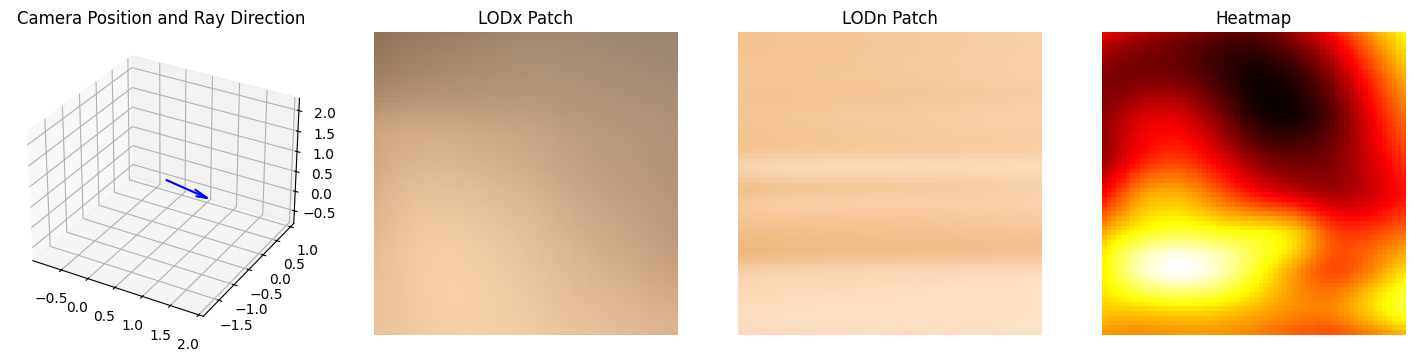

0.5452937381013939
18.122302226814107


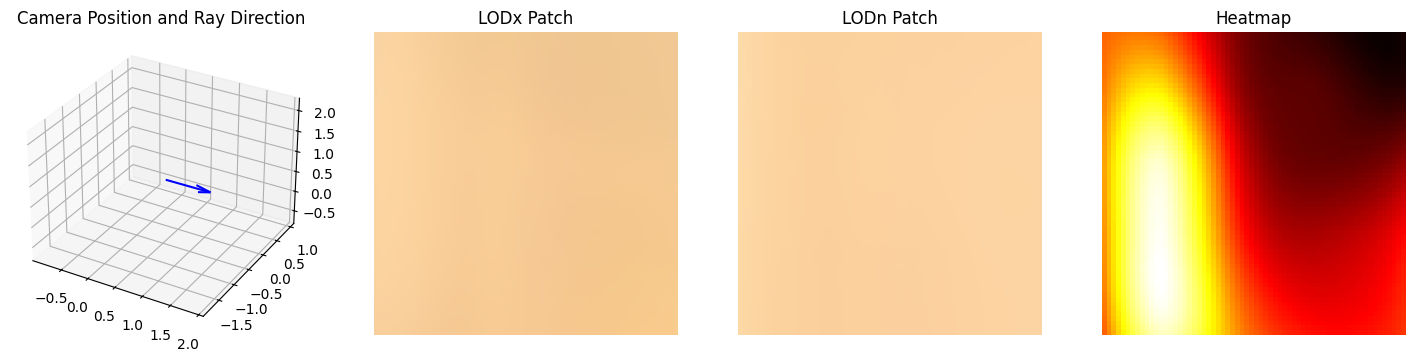

0.7273395154490523
1.509670223414728


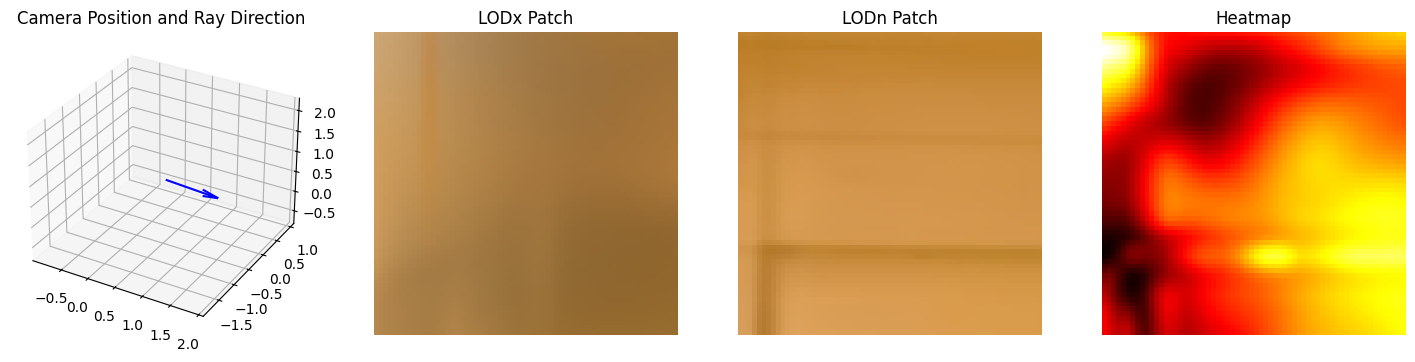

0.7049064696074523
1.509670223414728


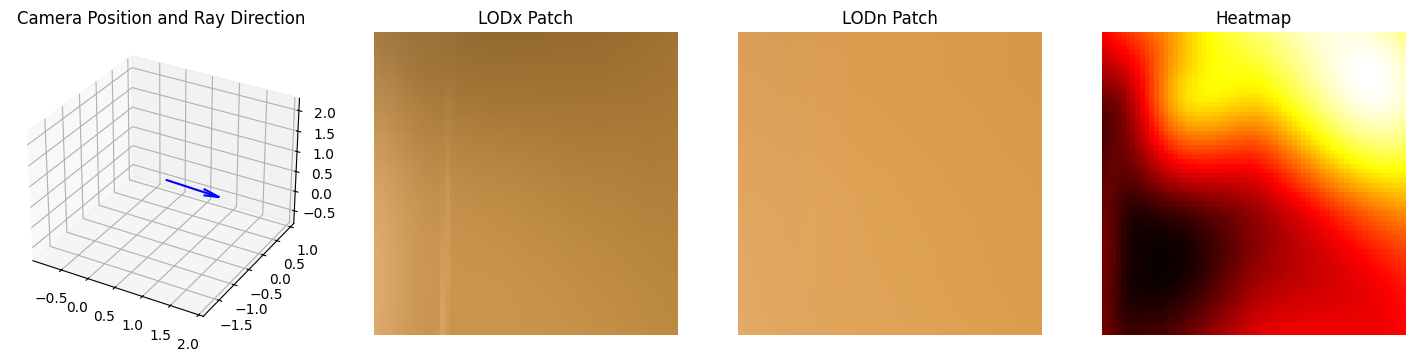

0.7091126013183289
1.509670223414728


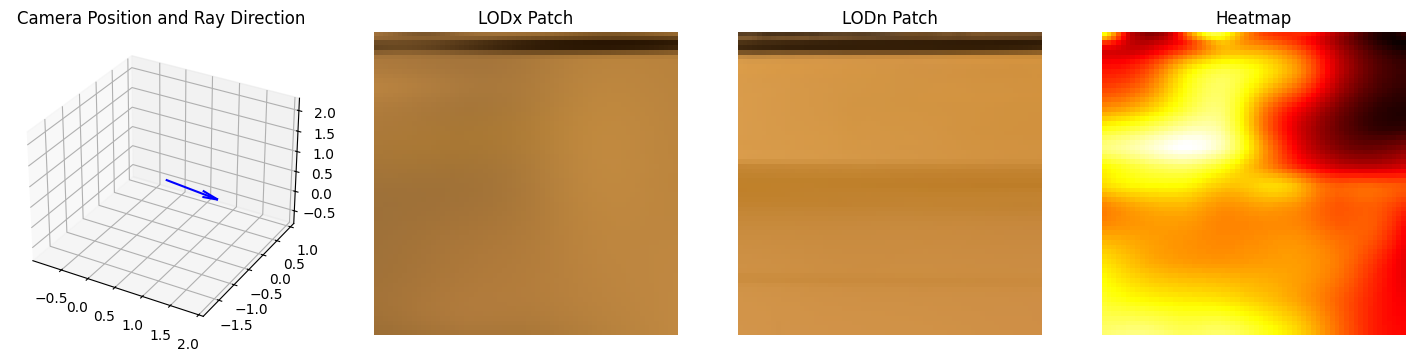

0.7339157783512602
1.509670223414728


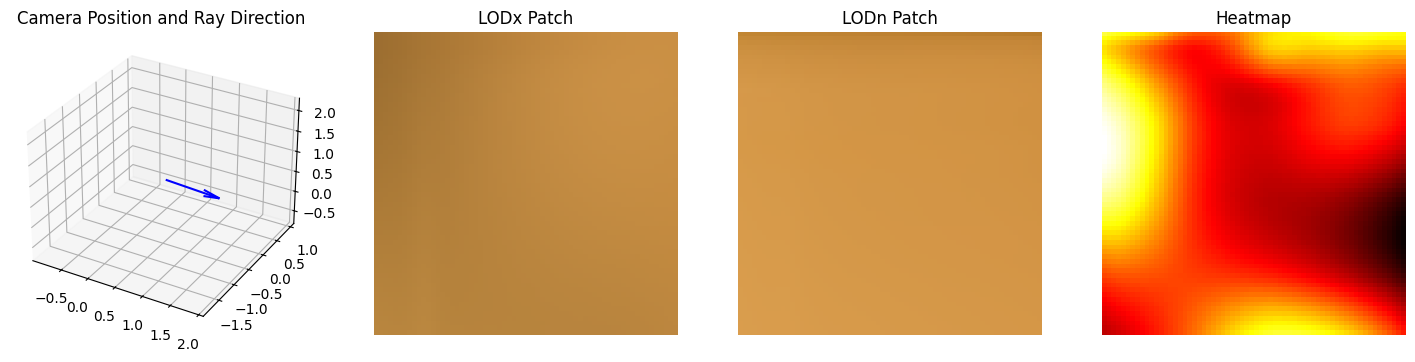

0.7391165875130028
1.509670223414728


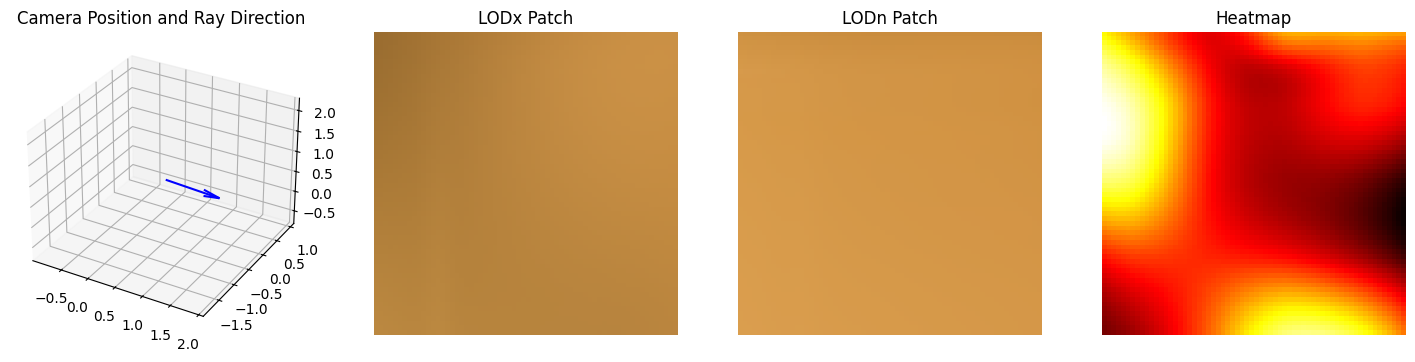

0.7283293845738414
1.509670223414728


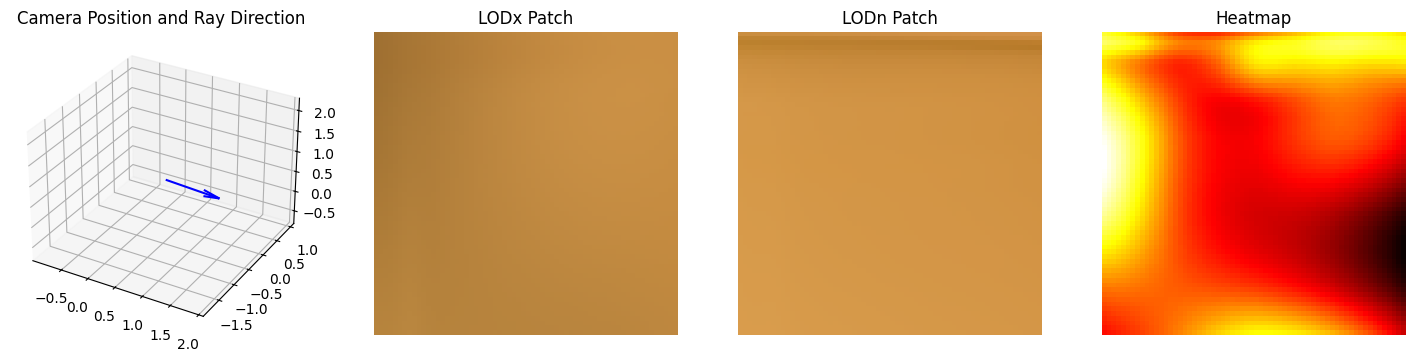

0.73583716805793
1.509670223414728


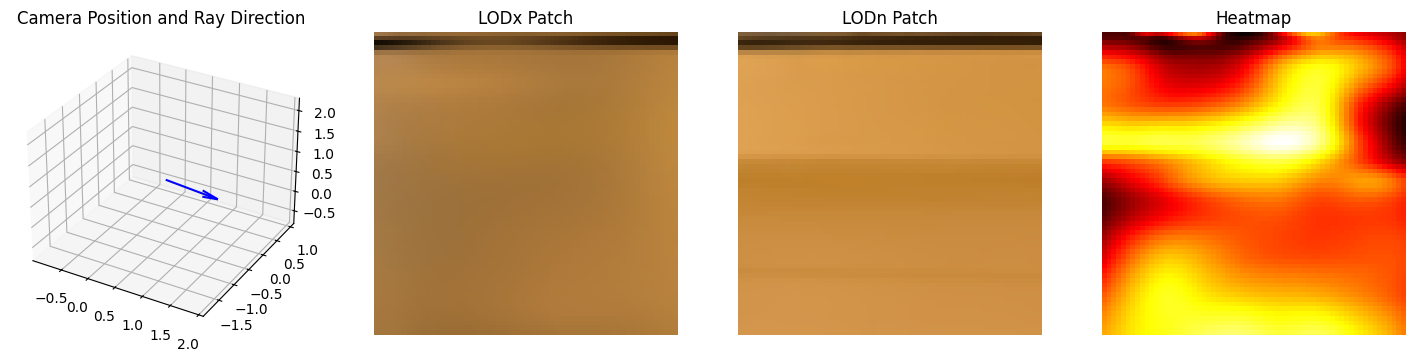

0.7179728637009484
1.509670223414728


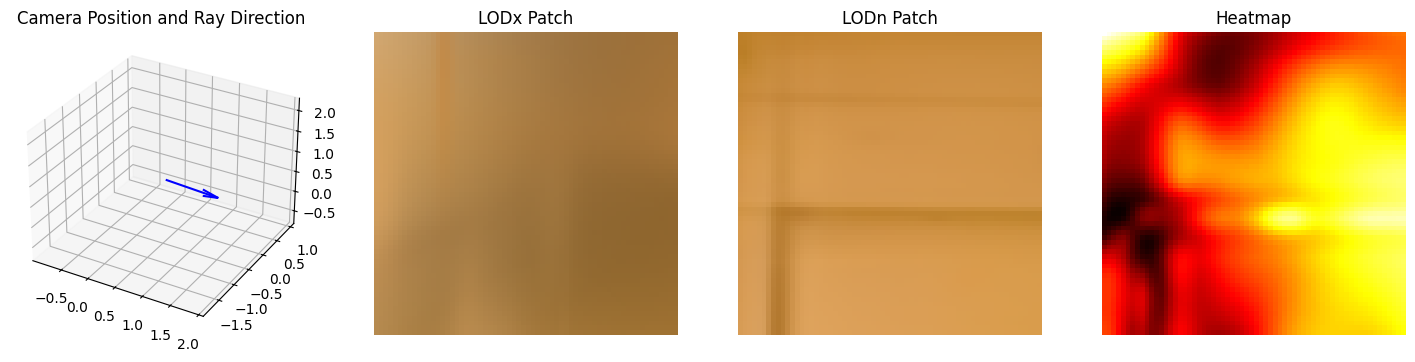

0.7850464975826983
0.7421948746271572


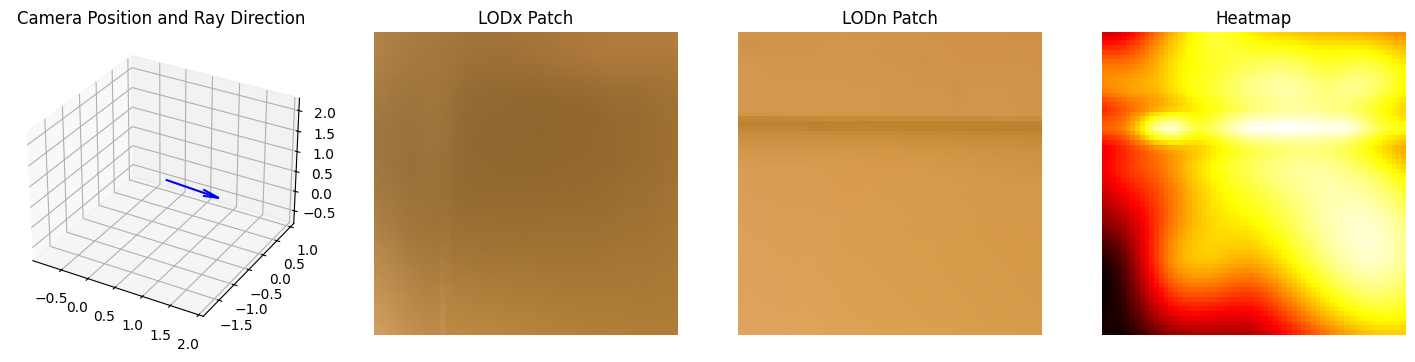

0.7795224192251375
0.7421948746271572


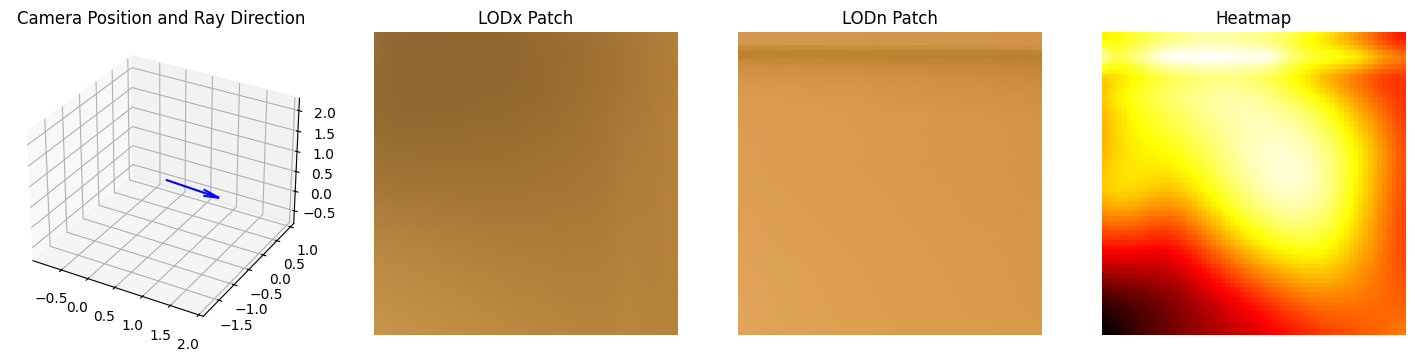

0.7730054491300438
0.7421948746271572


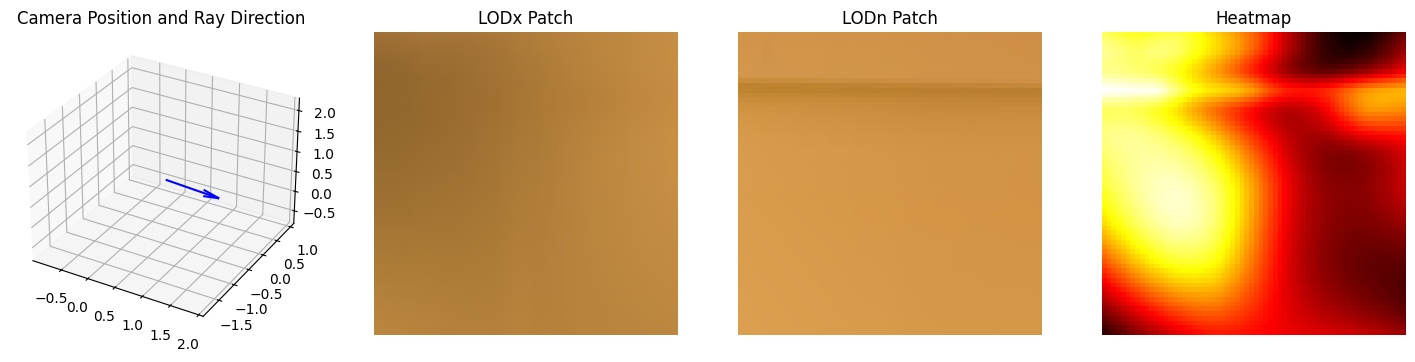

0.7734425411567369
0.7421948746271572


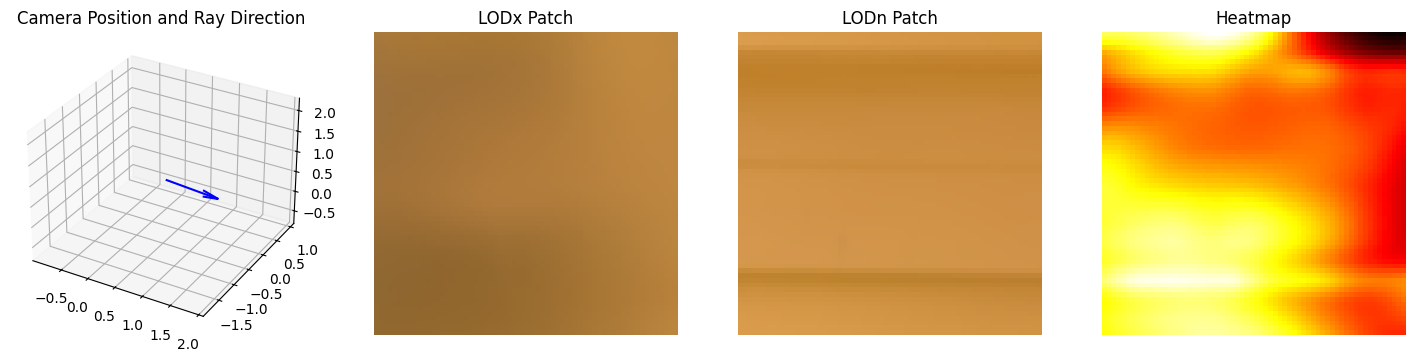

0.7808244489610624
0.7421948746271572


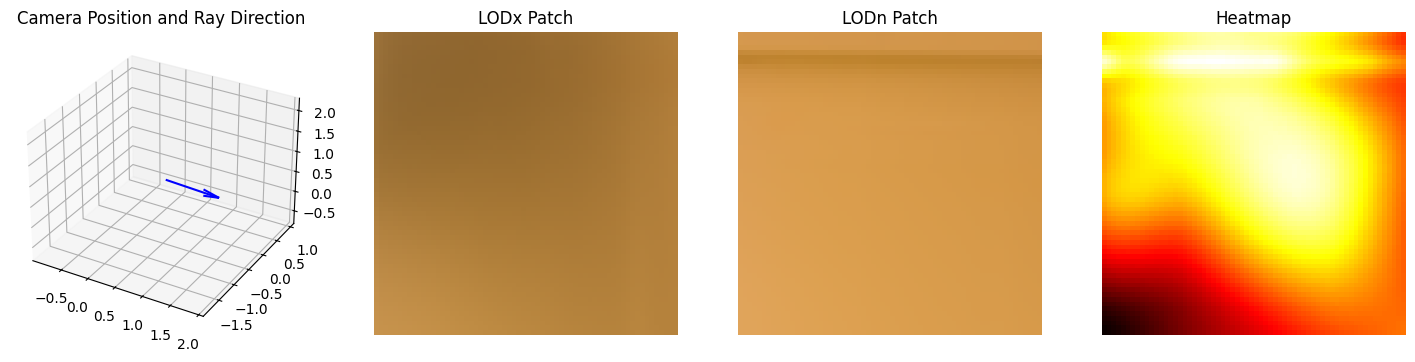

0.7844024105576198
0.7421948746271572


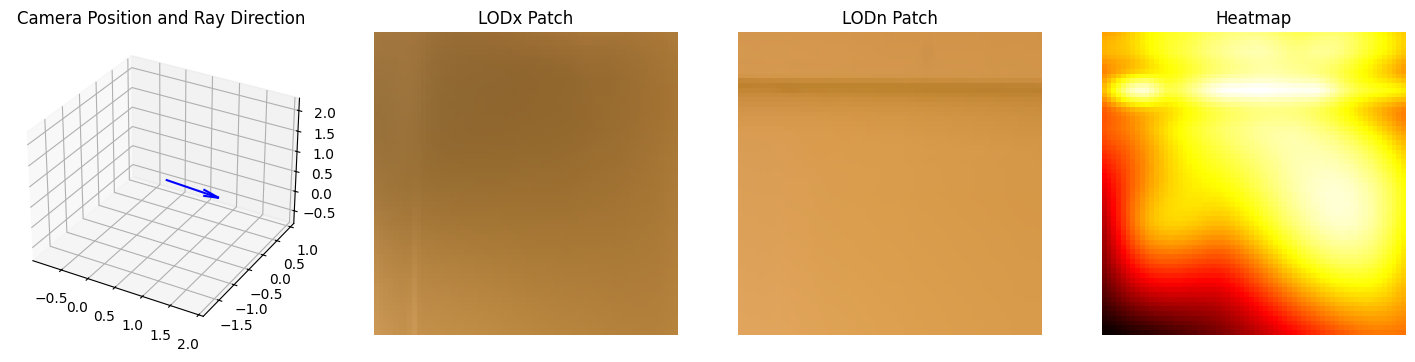

0.7723142923410211
0.7421948746271572


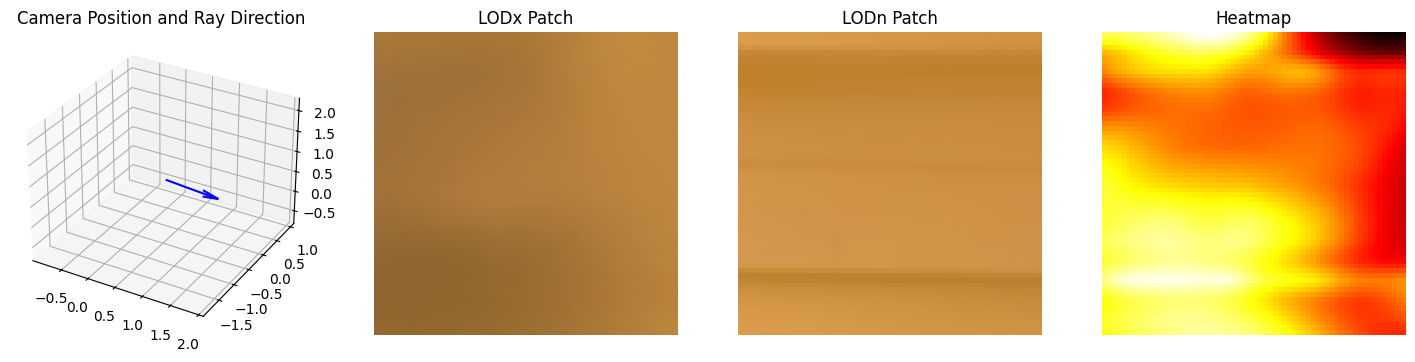

0.7711066018078105
0.7421948746271572


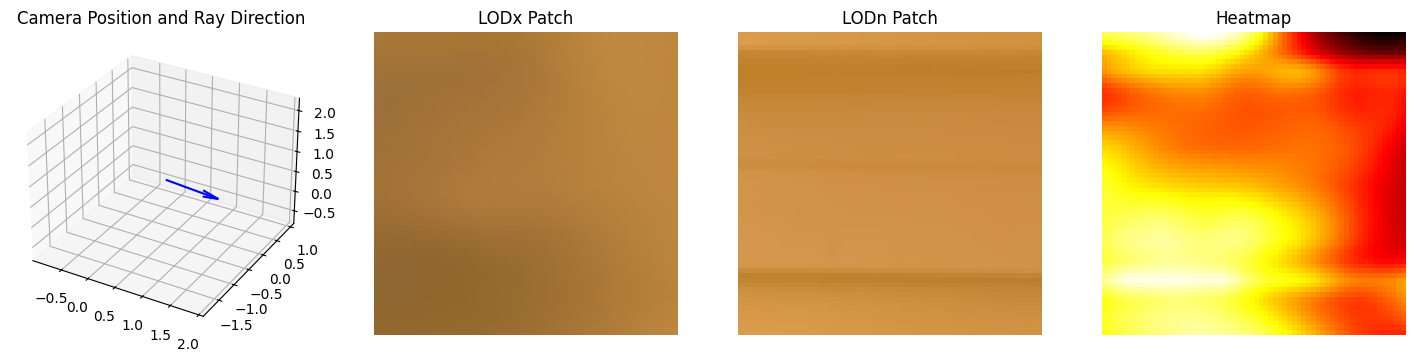

0.7618127003061425
0.7421948746271572


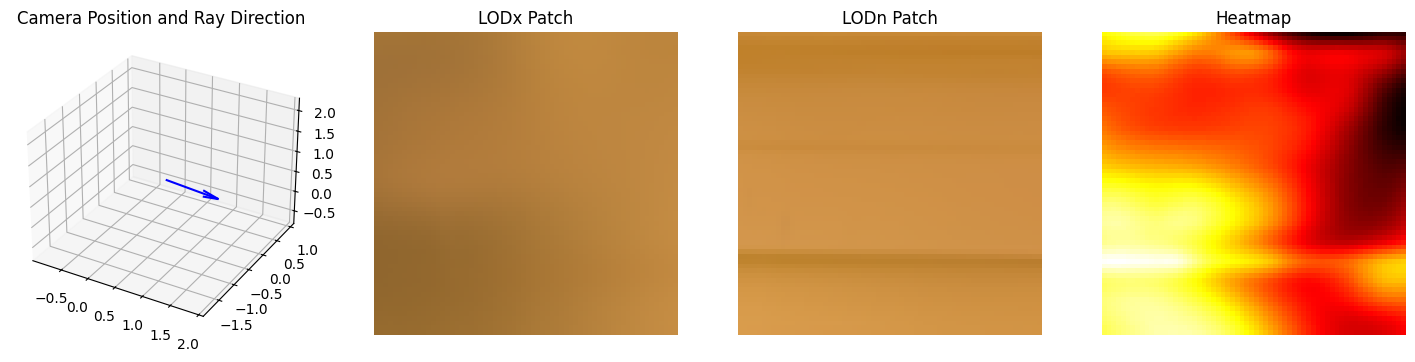

0.7815008557455483
0.7421948746271572


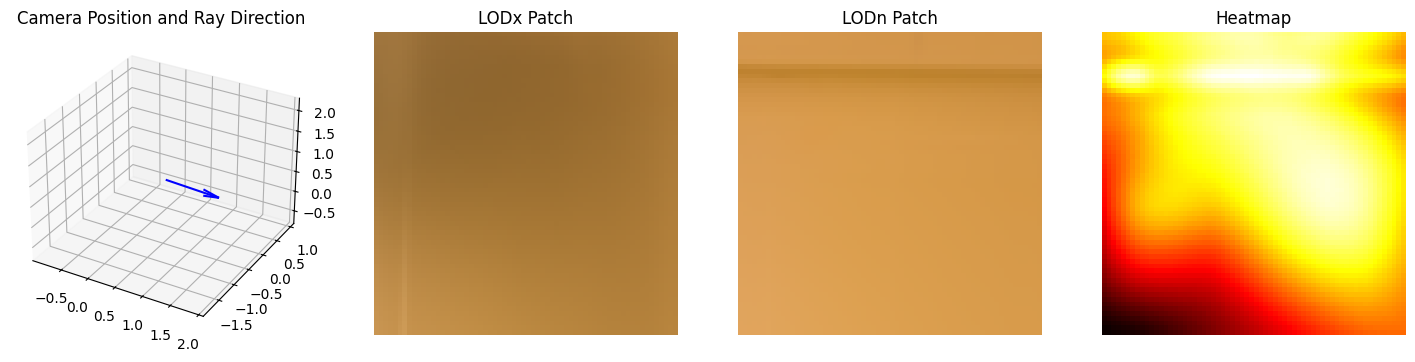

0.4609730857781161
7.40240458254261


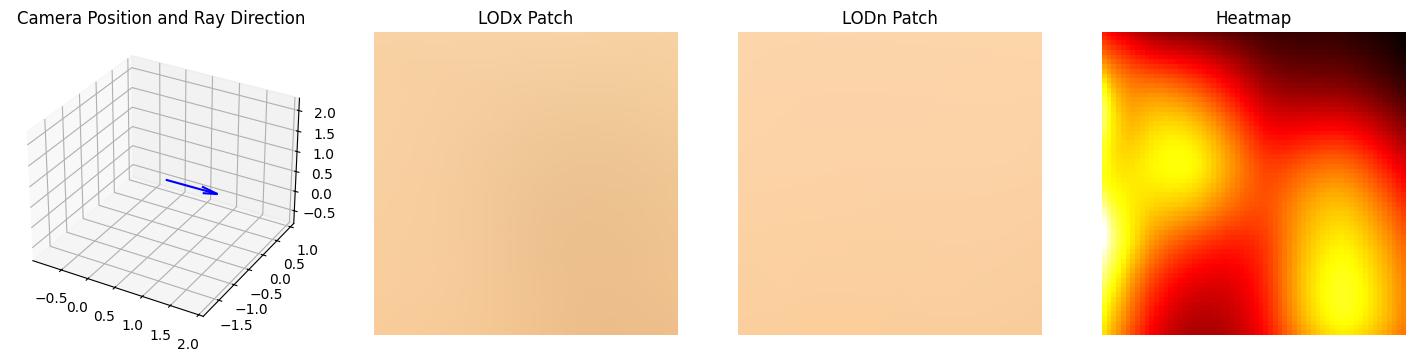

0.2586009363197782
7.40240458254261


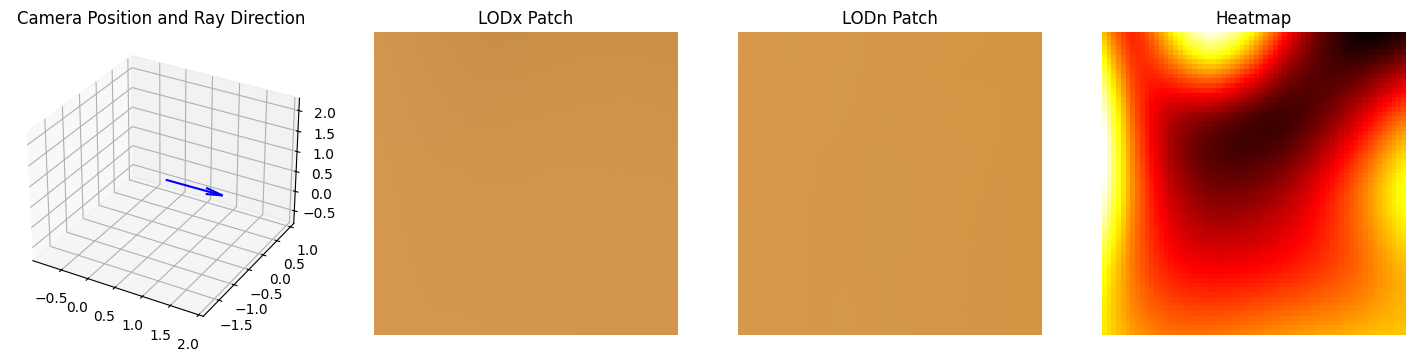

0.0
7.40240458254261


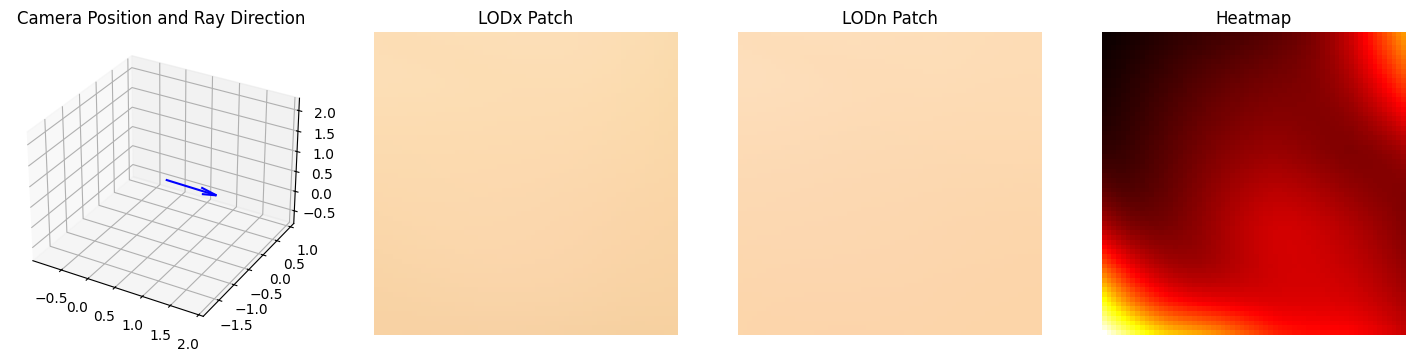

0.3346876861651943
7.40240458254261


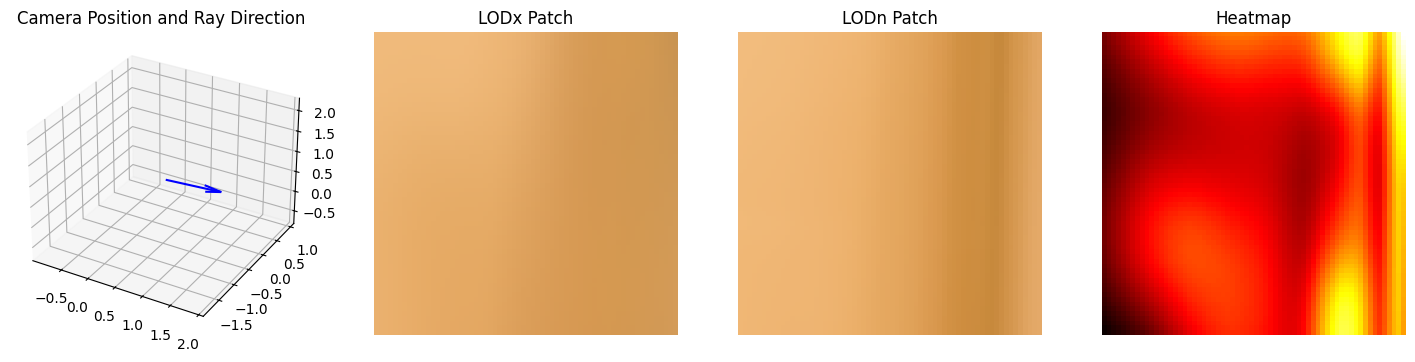

0.2152327360513497
7.40240458254261


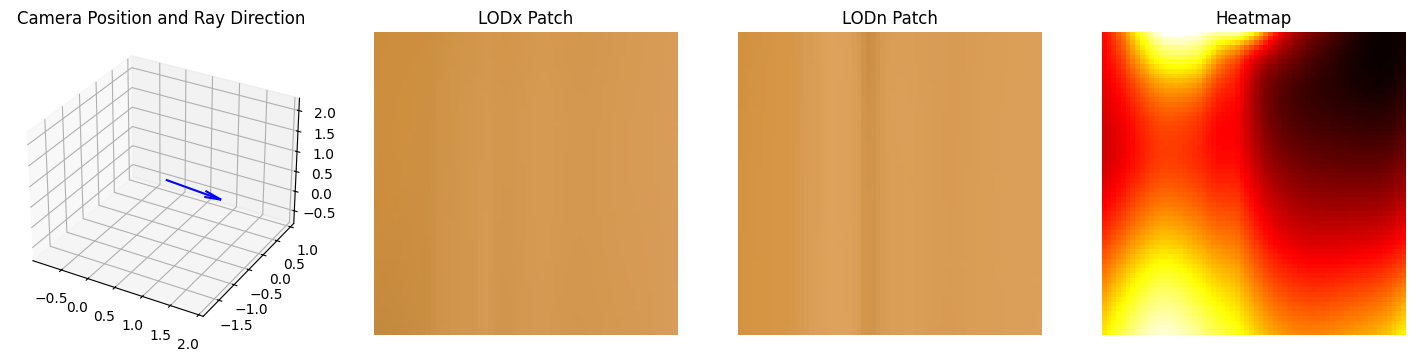

0.0
7.40240458254261


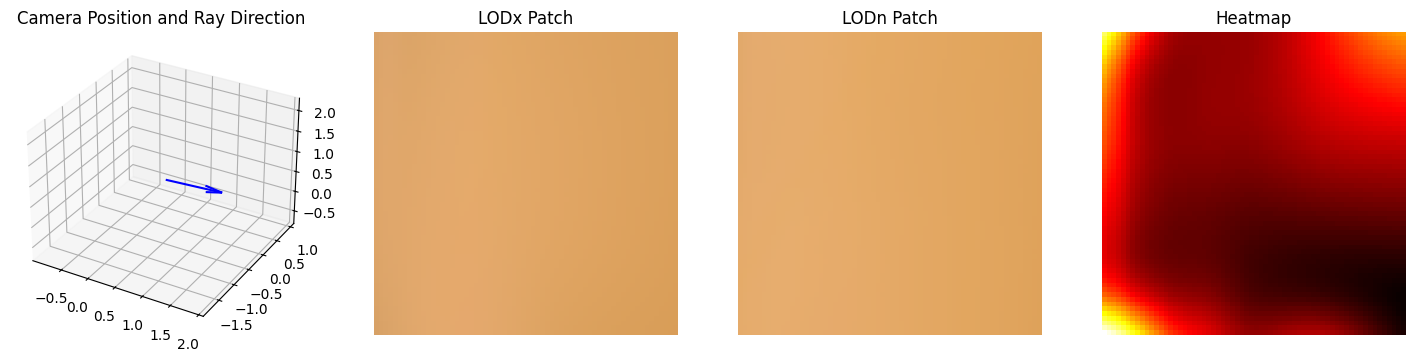

0.2862023677226633
7.40240458254261


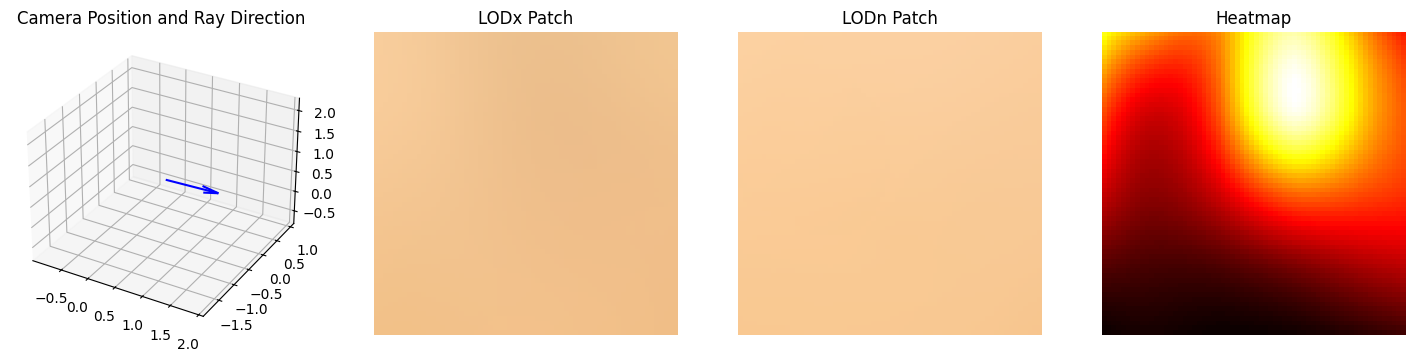

0.2205891643350453
7.40240458254261


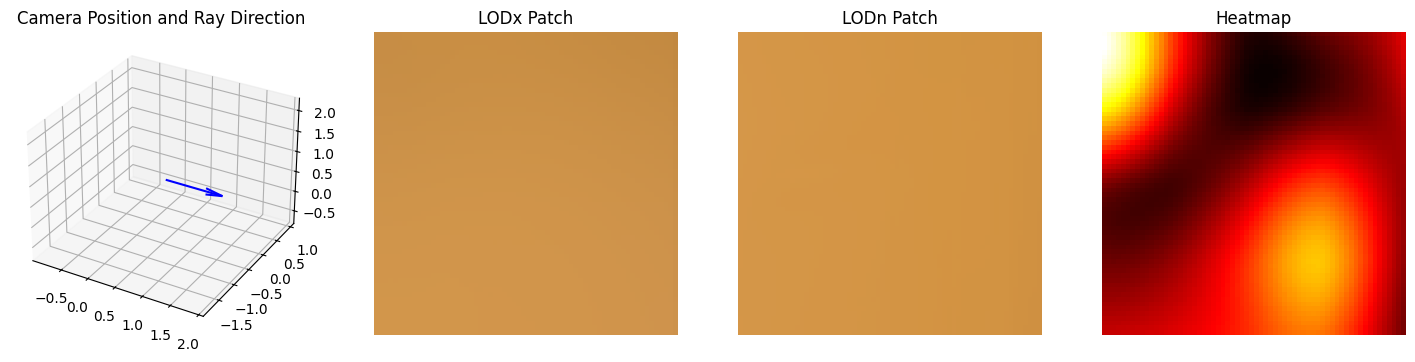

0.386890150127993
7.40240458254261


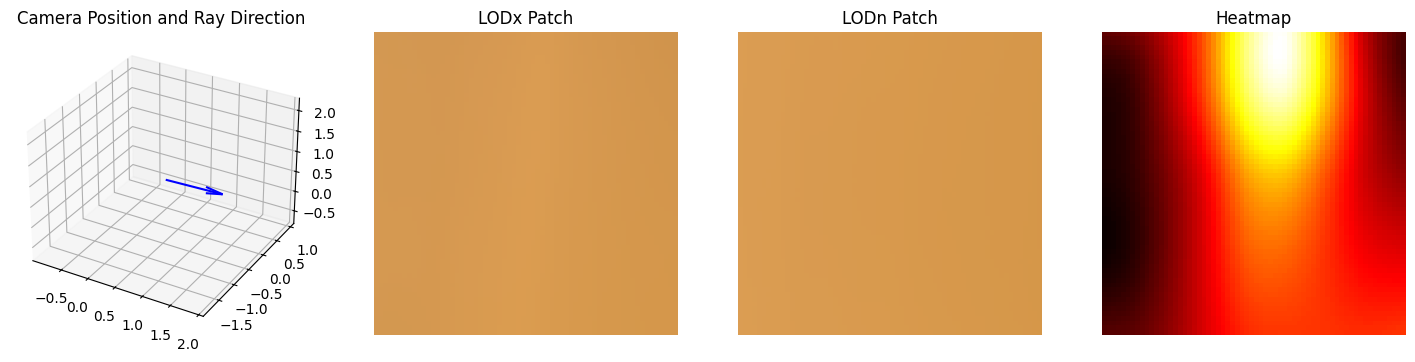

0.2865732472917173
7.40240458254261


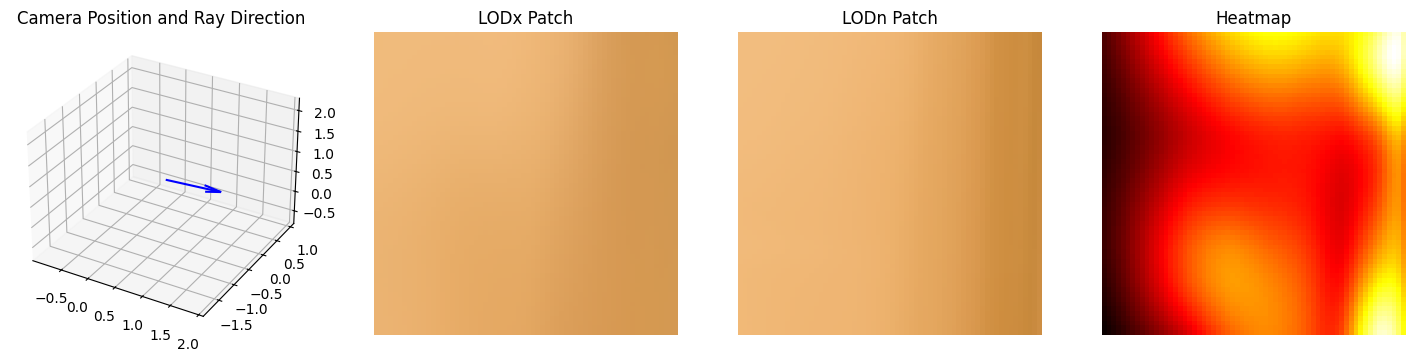

0.7009115495985834
5.841519826625734


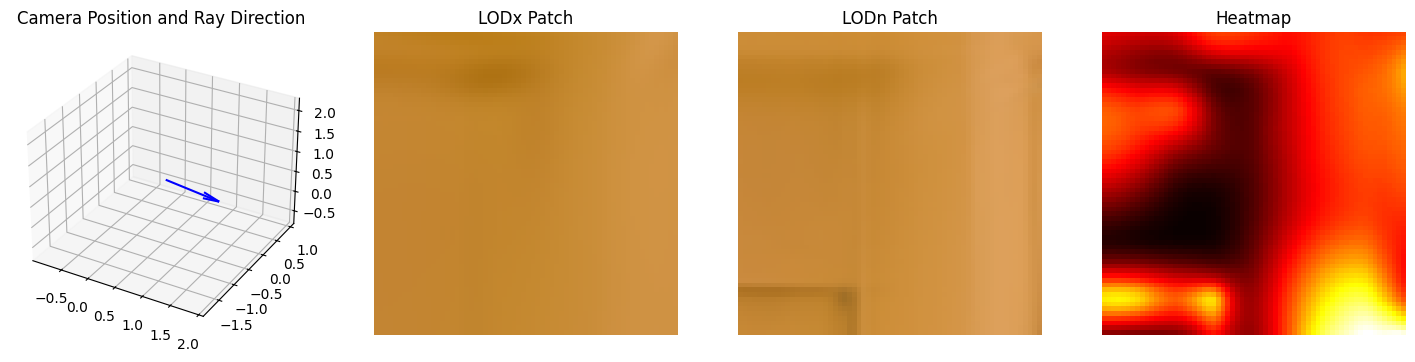

0.0177276734896337
5.841519826625734


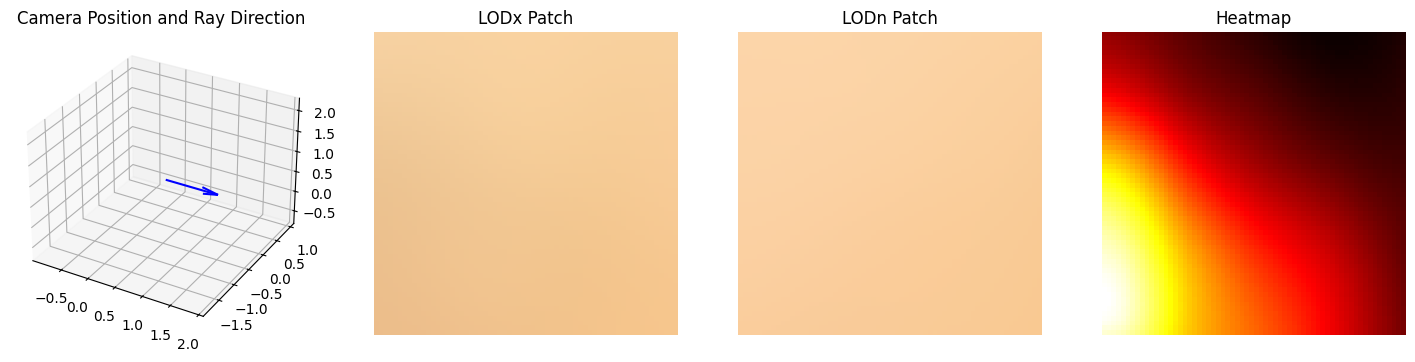

0.0
5.841519826625734


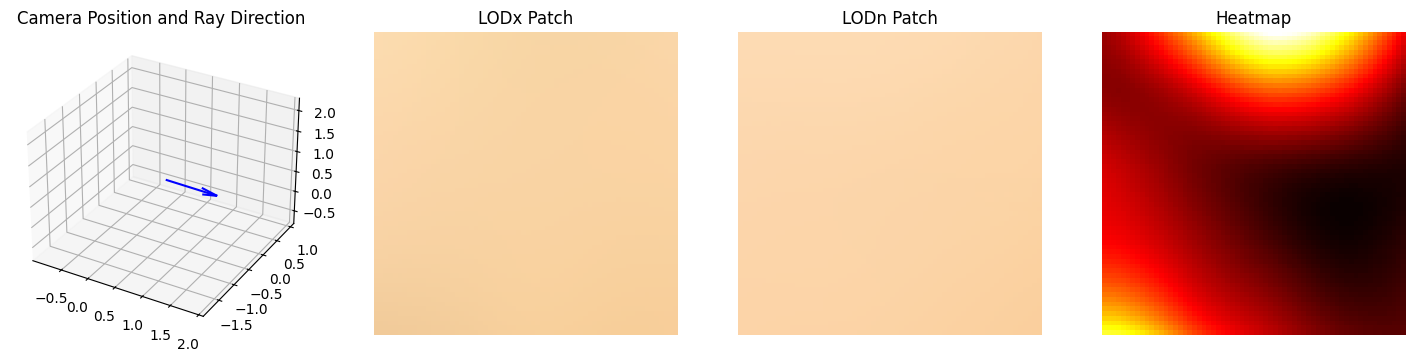

0.5228064500667378
5.841519826625734


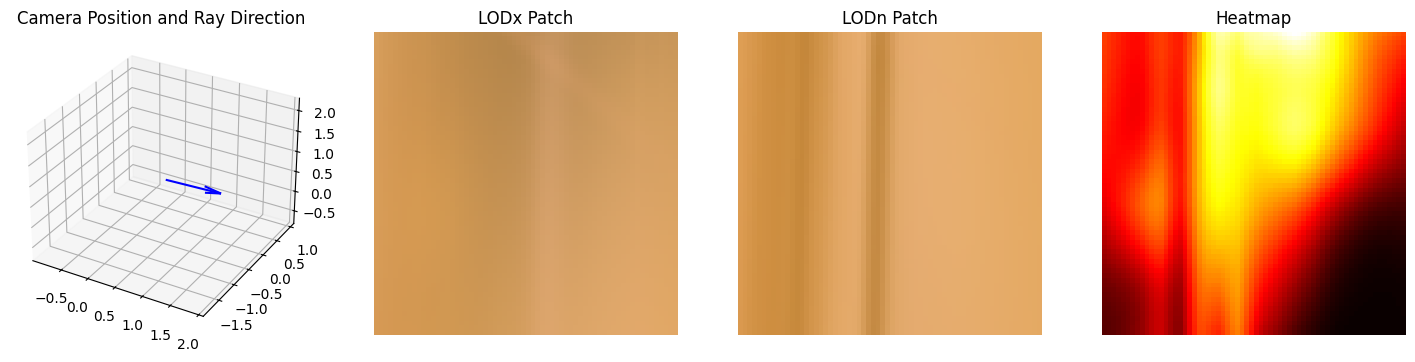

0.0
5.841519826625734


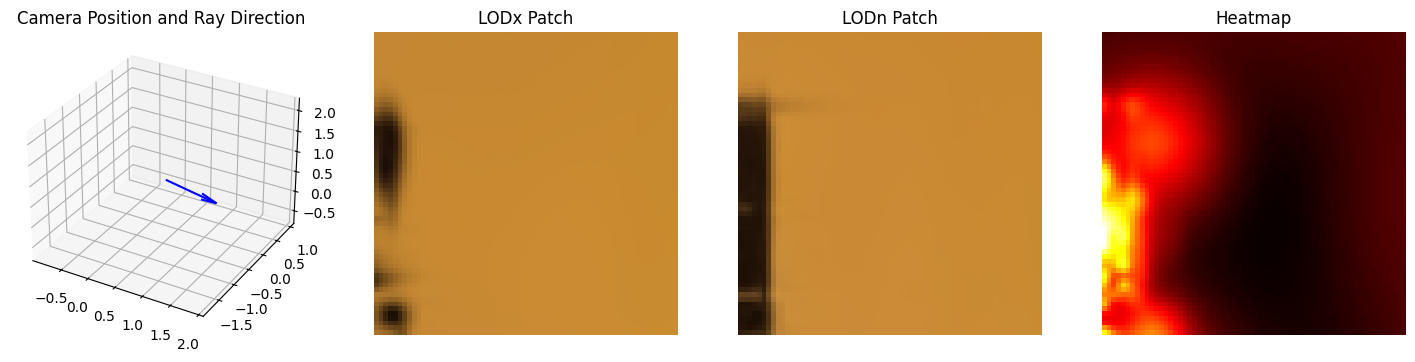

0.3397593302732157
5.841519826625734


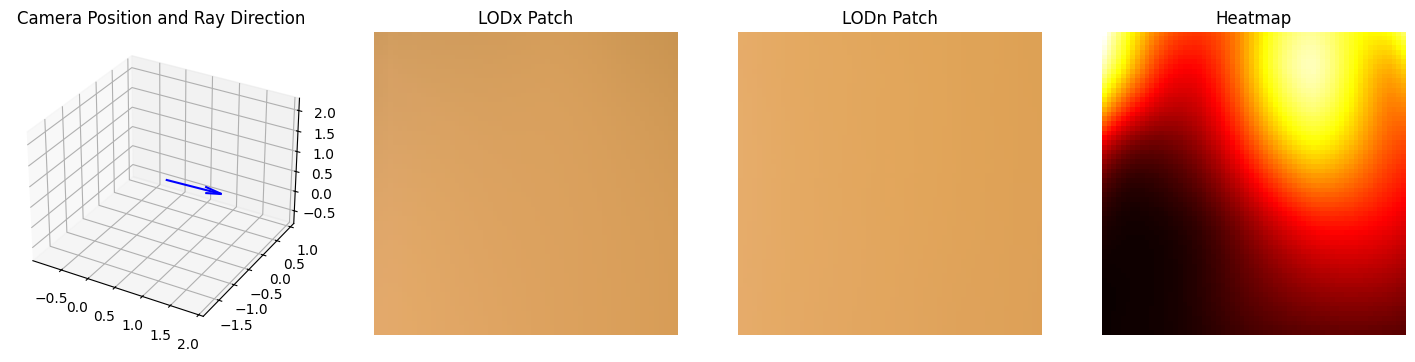

0.0
5.841519826625734


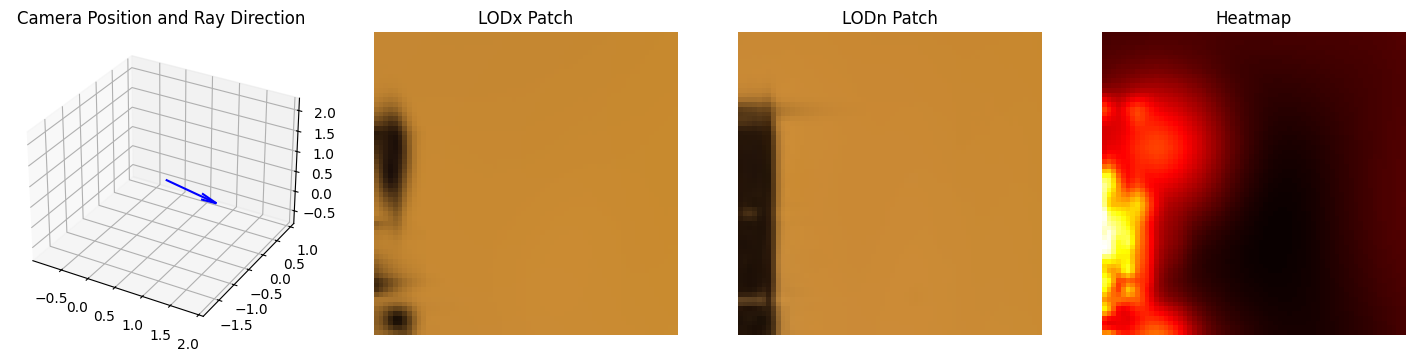

0.0
5.841519826625734


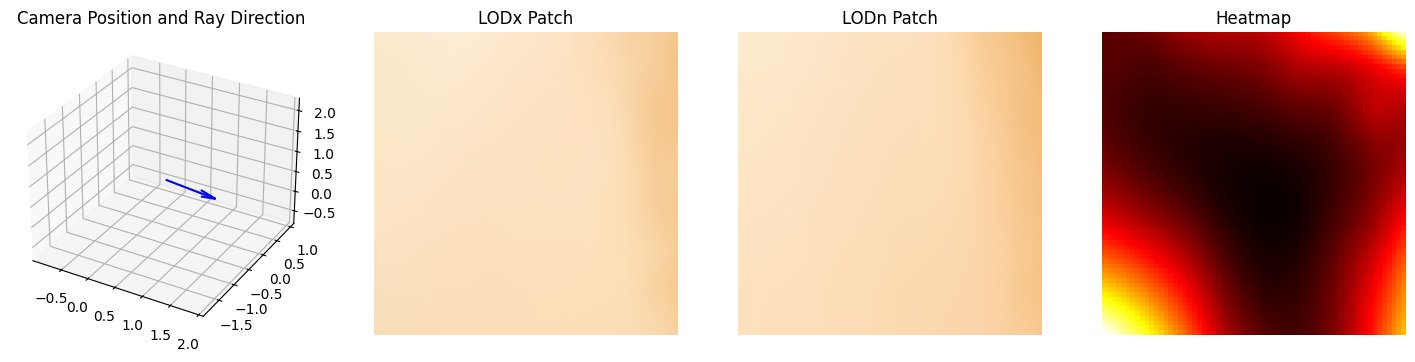

0.059125599841477
5.841519826625734


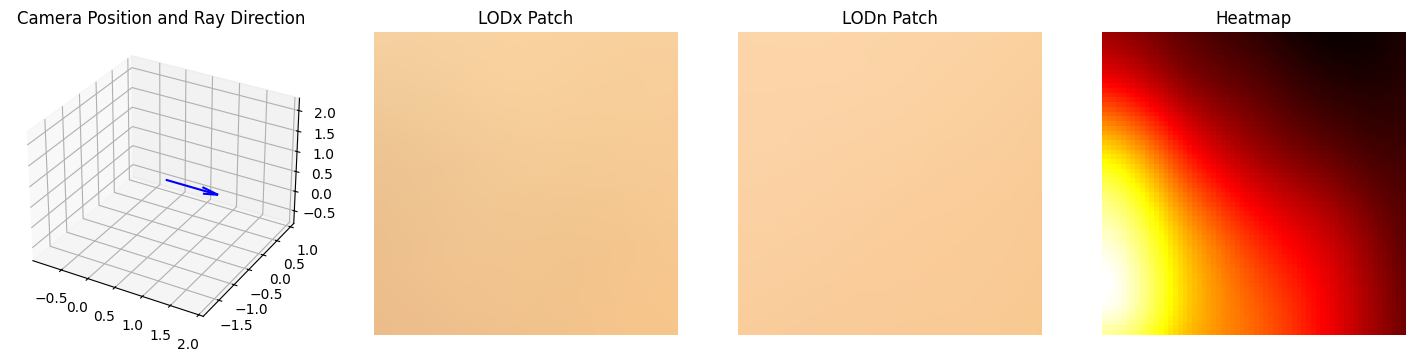

0.4911110798750118
5.841519826625734


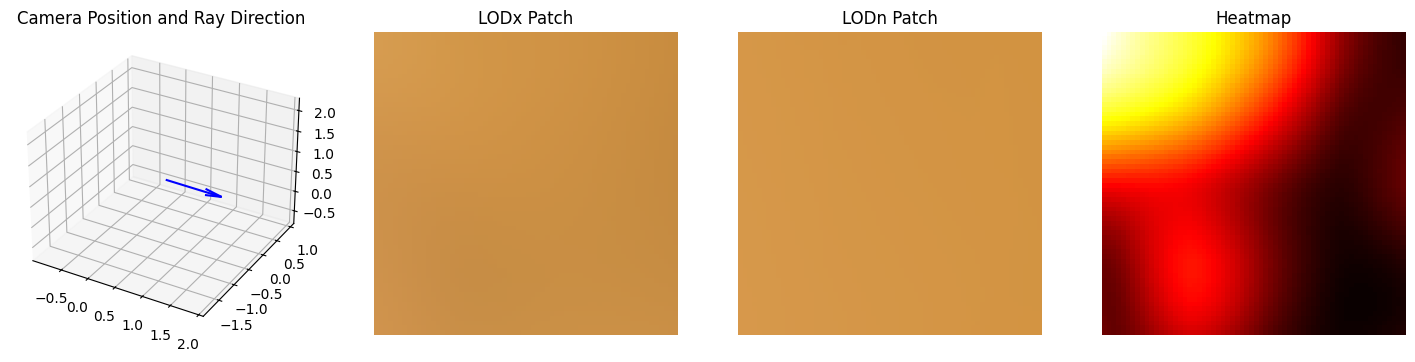

0.6151575860260132
9.381979192400255


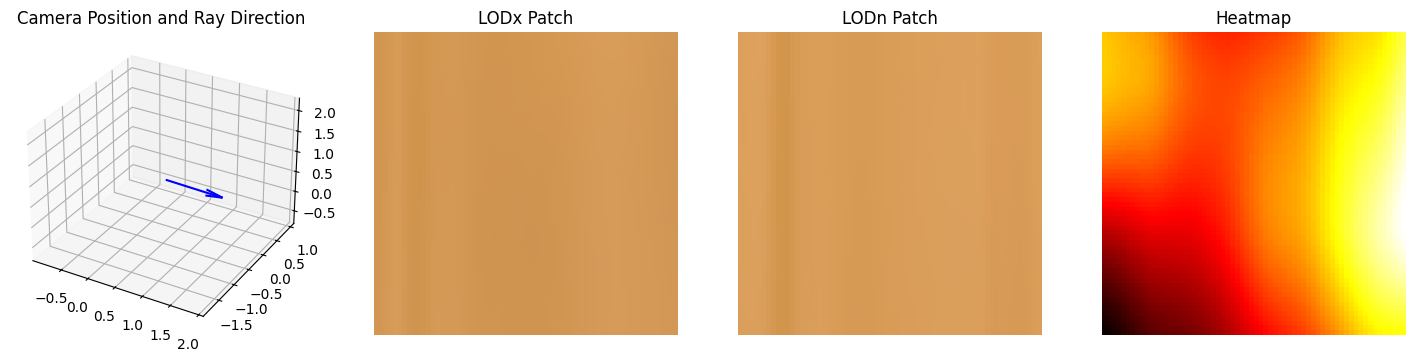

0.6789131771914885
9.381979192400255


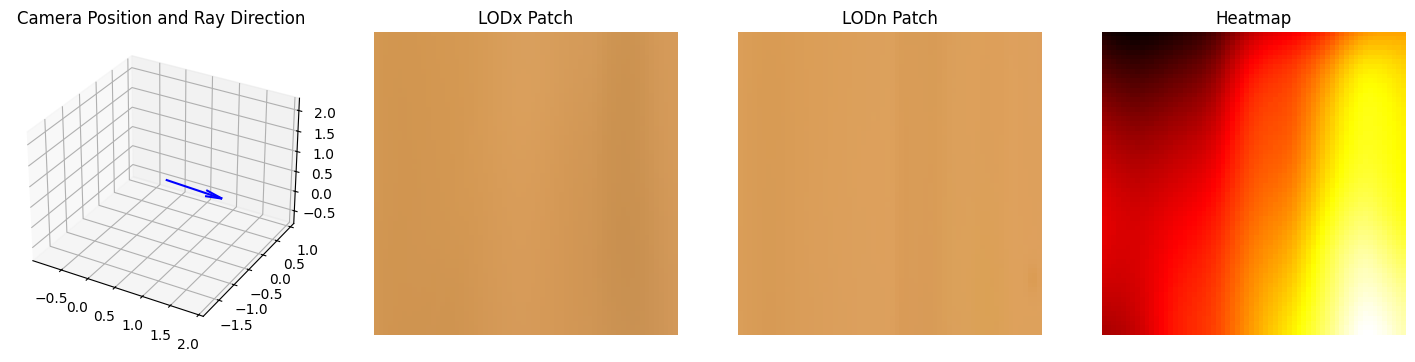

0.6947708837154991
9.381979192400255


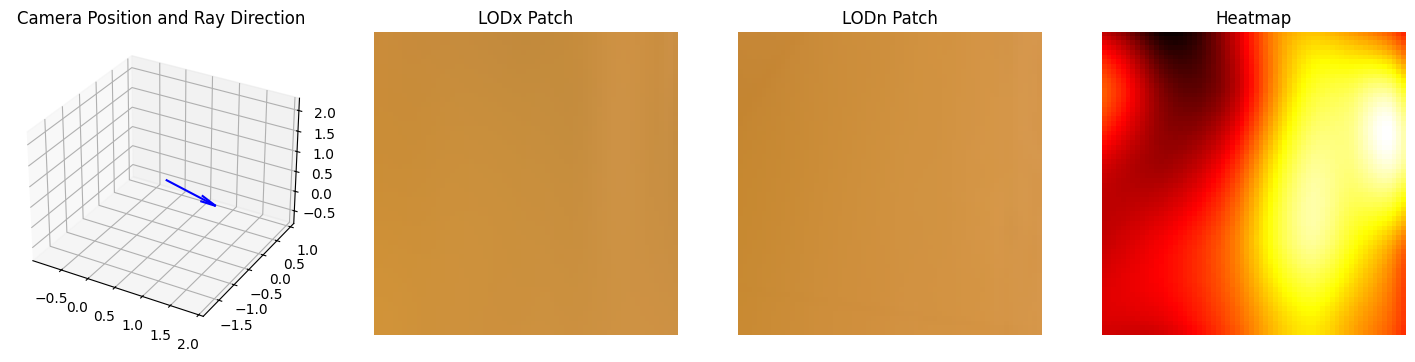

0.5074559365677053
9.381979192400255


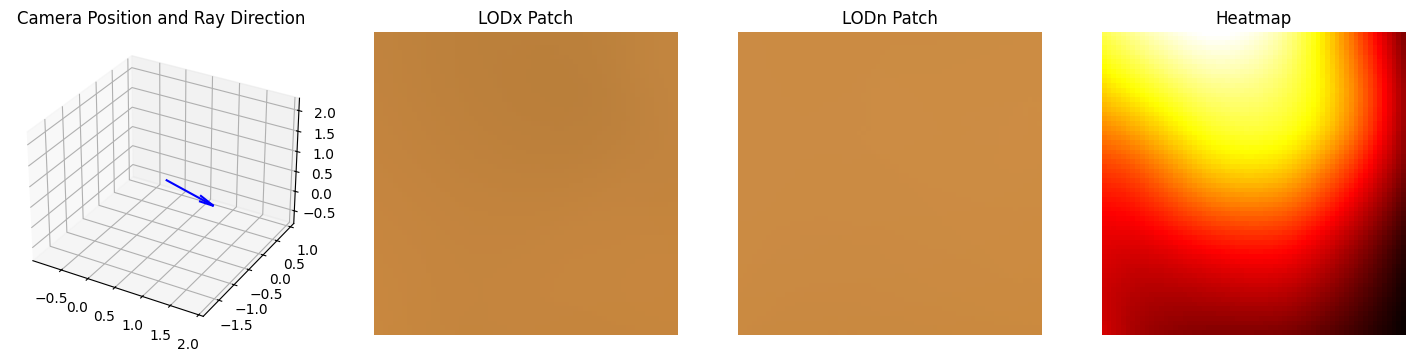

0.4131504071669032
9.381979192400255


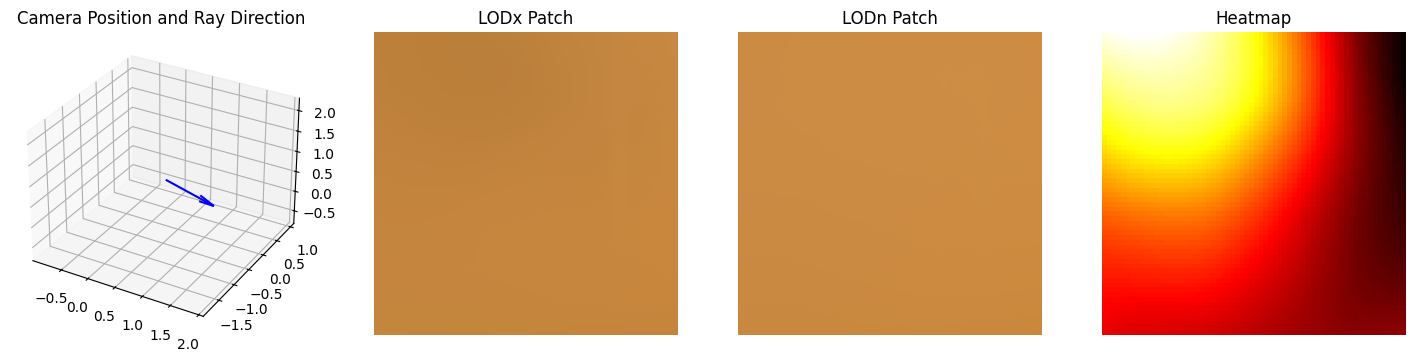

0.926532187063965
9.381979192400255


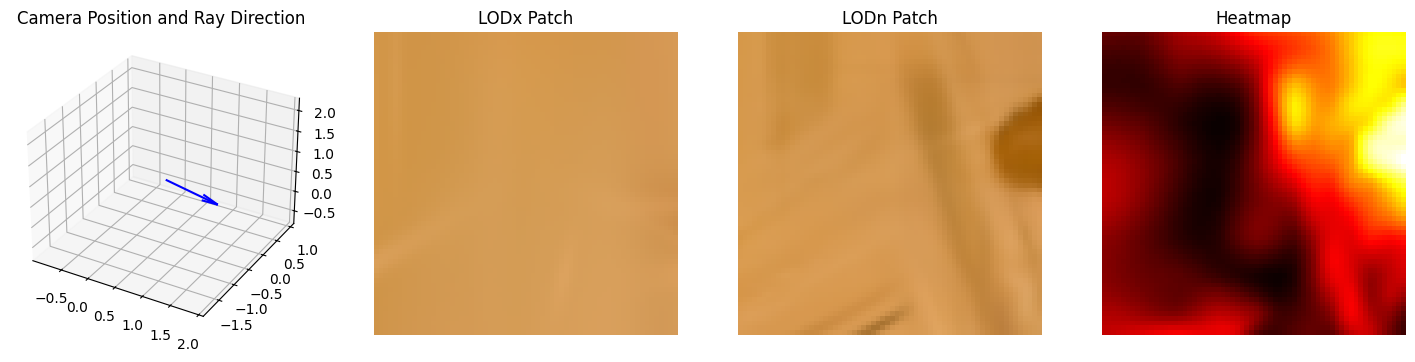

0.4359191554302535
9.381979192400255


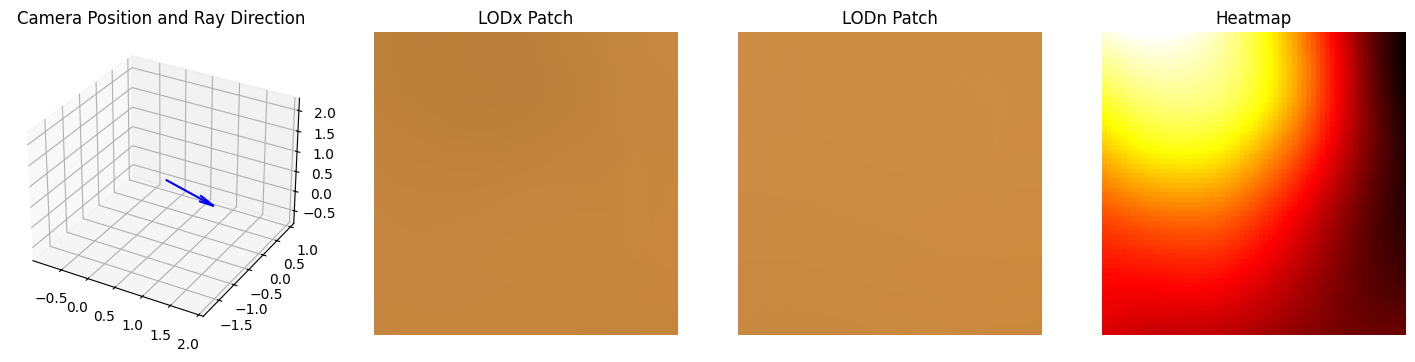

0.8479123282027483
9.381979192400255


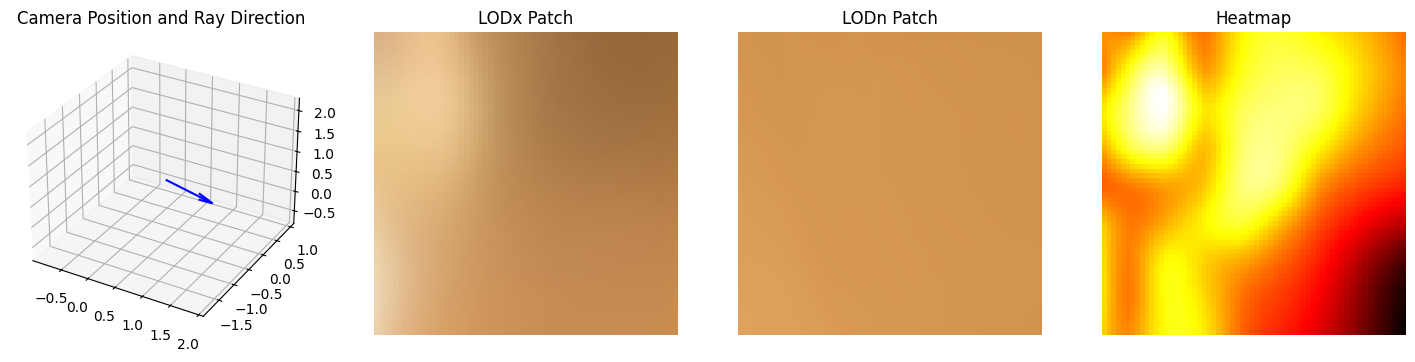

0.1681429591905595
9.381979192400255


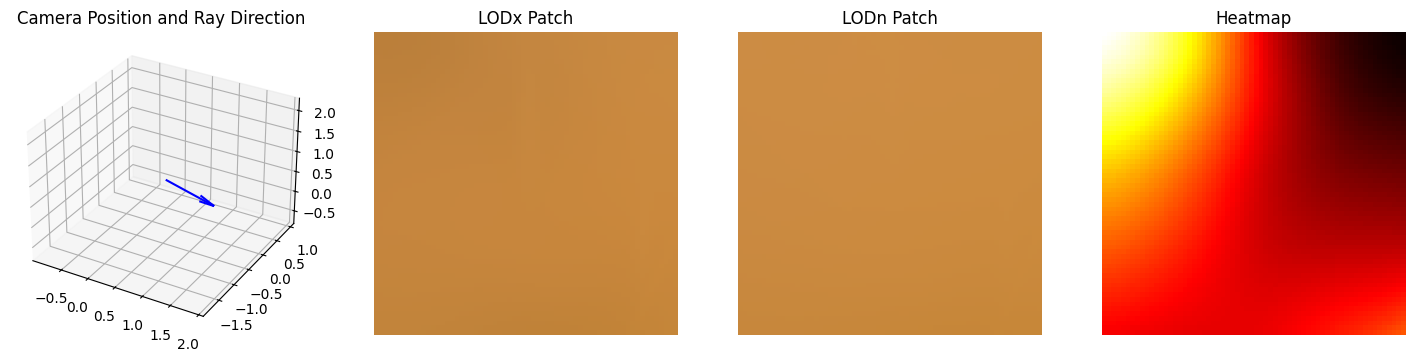

0.8554920877840554
9.381979192400255


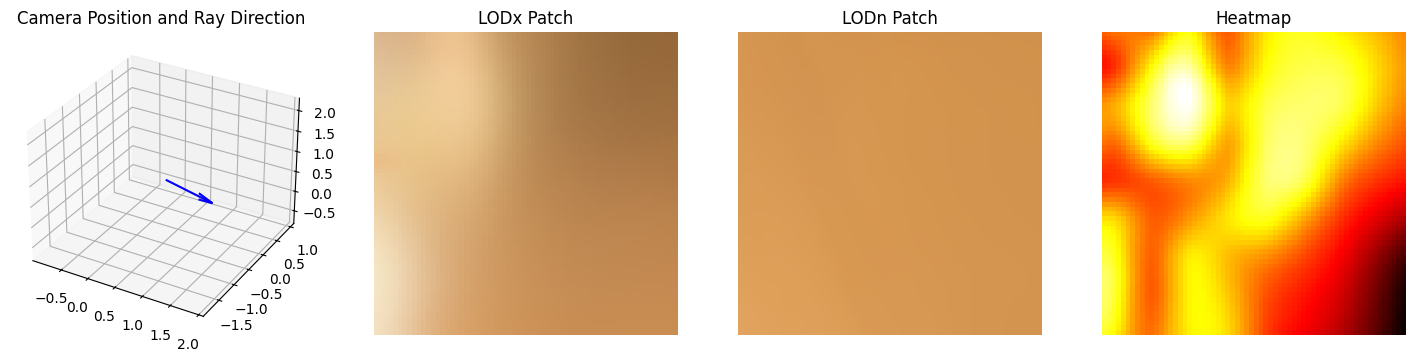

In [34]:
from lod_fvvdp_continous import LODFvvdpEccentricityContinous
metadata_path = 'playroom_lod_ecc_cont'  # Path to your metadata CSV
dataset = LODFvvdpEccentricityContinous(metadata_path, 'playroom_lod_ecc_cont')
samples = dataset.get_all_by_view_index(14)
for sample in samples[:50]:
    
    plot_sample(sample)

100


/tmp/ipykernel_14579/2607673127.py:37: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  ray_dir = np.fromstring(entry['ray_dir'].strip("[]"), sep=',')


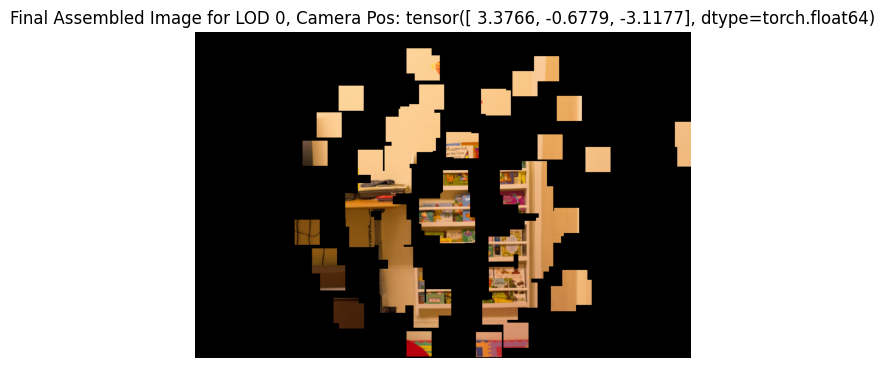

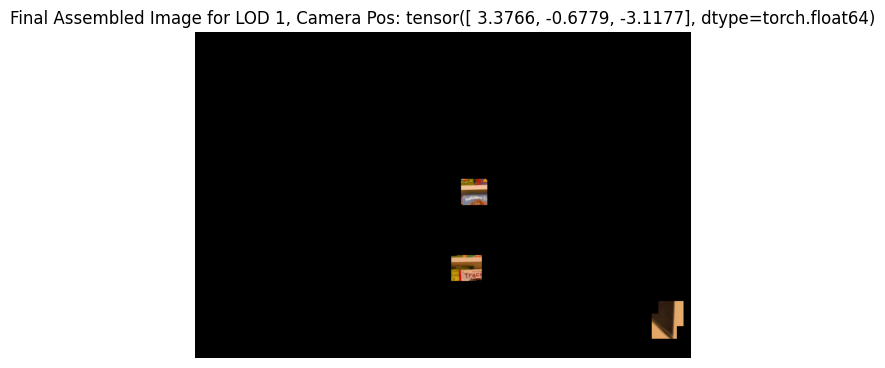

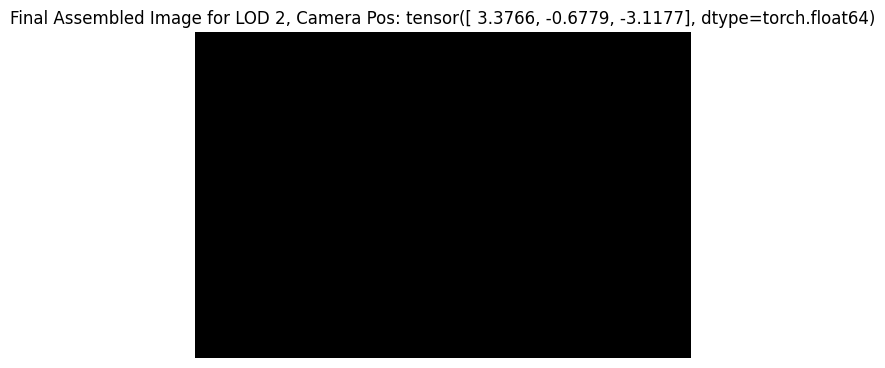

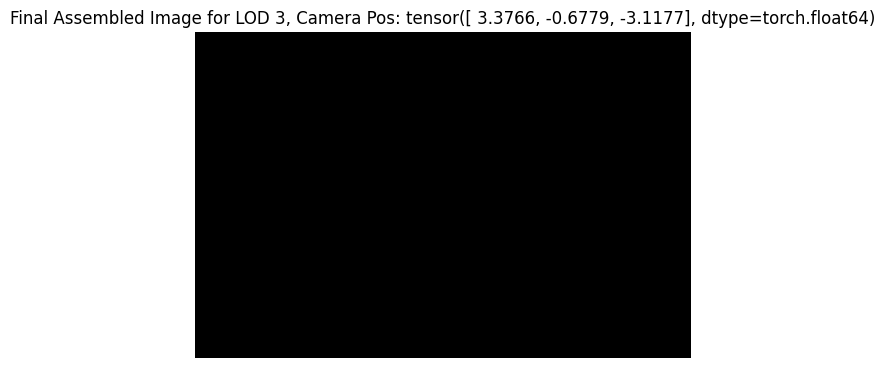

In [2]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

def assemble_image(dataset, img_width, img_height, ppd, chosen_camera_pos):
    """
    Assemble an image from patches based on their ray direction and eccentricity, handling edge cases,
    for a specific camera position.
    
    Args:
        dataset (LODFvvdpEccentricityContinous): The dataset containing the entries.
        img_width (int): The width of the output image.
        img_height (int): The height of the output image.
        ppd (int): Pixels per degree, used for scaling the eccentricity to pixel units.
        chosen_camera_pos (str): The camera position for which to generate the image.
    """
    # Filter entries by chosen camera position
    camera_pos_entries = dataset.metadata[dataset.metadata['camera_position'] == chosen_camera_pos]

    print(len(camera_pos_entries))
    for lod_level in range(camera_pos_entries['lod_n'].max() + 1):
        # Filter entries for the current LOD level
        current_lod_entries = camera_pos_entries[camera_pos_entries['lod_x'] == lod_level]

        # Create an empty image
        final_image = np.zeros((img_height, img_width, 3), dtype=np.uint8)

        for index, entry in current_lod_entries.iterrows():
            ray_dir = np.fromstring(entry['ray_dir'].strip("[]"), sep=',')
            eccentricity = entry['eccentricity']
            theta = entry['theta']

            # Calculate coordinates
            x, y = sample_eccentricity_coordinates(img_width, img_height, eccentricity, theta, ppd)

            # Load the patch
            patch = torch.load(entry['lod_n_path'])
            patch = (patch * 255).astype(np.uint8)  # Assuming patch is normalized

            # Calculate patch dimensions
            patch_height, patch_width, _ = patch.shape

            # Determine the region of the image that the patch will occupy
            start_x = max(x, 0)
            start_y = max(y, 0)
            end_x = min(x + patch_width, img_width)
            end_y = min(y + patch_height, img_height)

            # Determine the region of the patch to use
            patch_start_x = start_x - x if x < 0 else 0
            patch_start_y = start_y - y if y < 0 else 0
            patch_end_x = patch_width - (x + patch_width - img_width) if x + patch_width > img_width else patch_width
            patch_end_y = patch_height - (y + patch_height - img_height) if y + patch_height > img_height else patch_height

            # Place the patch into the image
            final_image[start_y:end_y, start_x:end_x] = patch[patch_start_y:patch_end_y, patch_start_x:patch_end_x]

        # Display the image using matplotlib
        plt.imshow(final_image)
        plt.title(f"Final Assembled Image for LOD {lod_level}, Camera Pos: {chosen_camera_pos}")
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.show()

def sample_eccentricity_coordinates(img_width, img_height, eccentricity_deg, theta, pixels_per_deg):
    """
    Calculate the pixel coordinates for a given eccentricity degree value based on provided formula.
    """
    eccentricity_pixels = eccentricity_deg * pixels_per_deg
    x = int(img_width / 2 + eccentricity_pixels * np.cos(theta))
    y = int(img_height / 2 + eccentricity_pixels * np.sin(theta))
    x = max(min(x, img_width - 1), 0)
    y = max(min(y, img_height - 1), 0)
    return x, y

# Example of how to call the function with a specific camera position
from lod_fvvdp_continous import LODFvvdpEccentricityContinous
metadata_path = 'playroom_lod_ecc_cont'  # Path to your metadata CSV
dataset = LODFvvdpEccentricityContinous(metadata_path, 'playroom_lod_ecc_cont')
img_width, img_height, ppd = 1264, 832, 32
chosen_camera_pos = 'tensor([ 3.3766, -0.6779, -3.1177], dtype=torch.float64)'  # Specify the camera position you want to generate an image for
assemble_image(dataset, img_width, img_height, ppd, chosen_camera_pos)